In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as io
from PIL import Image
import os
import cv2
import math
import time

import autograd.numpy as anp
from autograd import grad

import skimage
from skimage.transform import resize
from skimage import color



from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix


import tensorflow as tf
# from tensorflow import *
import keras
from tensorflow.keras import datasets, layers, models,callbacks
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

    
%matplotlib inline

In [3]:
#LOADING IMAGES FROM DATASET
def load_images_from_folder(folder):
    images = []
    names=[]
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            if folder=="D:/SEM 4/Project2/Images/signal_200" :
                names.append(0)
            else: names.append(1)
    return images, names

signal, s_names = load_images_from_folder("D:/SEM 4/Project2/Images/signal_200")
bg, bg_names = load_images_from_folder("D:/SEM 4/Project2/Images/background_200")


In [4]:
#PREPRCOESSING1: RESIZING AND CROPPING IMAGES
for i in range(len(signal)):
    signal[i] = signal[i][140:230,140:230]
    signal[i]=resize(color.rgb2gray(signal[i]),(64,64))
    bg[i]= bg[i][140:230,140:230]
    bg[i]=resize(color.rgb2gray(bg[i]),(64,64))

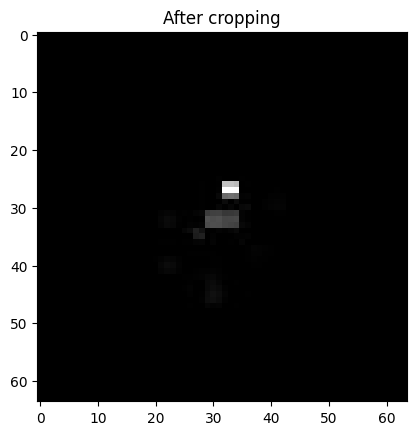

In [5]:
#EXAMPLE IMAGE AFTER PREPROCESSING

plt.imshow(signal[0], cmap='grey')
plt.title("After cropping")
plt.show()

# BLURRING IMAGES

In [7]:
#BLURRING THE IMAGE
# Define a blur function on the grid

x0 = np.linspace(-255.5, 255.5, 64, endpoint=True)
x, y = np.meshgrid(x0,x0)

# Square window psf
# h = np.sinc(x/5) * np.sinc(y/5)  # sinc blur function
h = np.exp(-(x**2 + y**2)/10)  # Gaussian psf extending everywhere
h[(np.abs(x)<5) * (np.abs(y)<5)] = 1 
h = h / np.sum(h[:])


In [8]:
#BLURRING SIGNAL IMAGES
signal_b=[]
for i in range(200):
    img=signal[i]
    # Blurred image
    A = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
    H = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(h)))
    b = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(A*H))))
    # print(str(i))
    # Add noise
    noise = np.random.rand(64,64) * 0.001 * np.mean(b[:])
    b = b + noise
    signal_b.append(b)
    io.imwrite('D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/1 Blurred images/Signal/'+'S'+str(i)+'.tiff',b)
    

In [9]:
#BLURRING BACKGROUND IMAGES
bg_b=[]
for i in range(len(bg)):
    img=bg[i]
    # Blurred image
    A = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
    H = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(h)))
    b = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(A*H))))
    
    # Add noise
    noise = np.random.rand(64,64) * 0.001 * np.mean(b[:])
    b = b + noise
    bg_b.append(b)
    cv2.imwrite("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/1 Blurred images/Background/"+'B'+str(i)+'.tiff',b)
    

<Figure size 640x480 with 0 Axes>

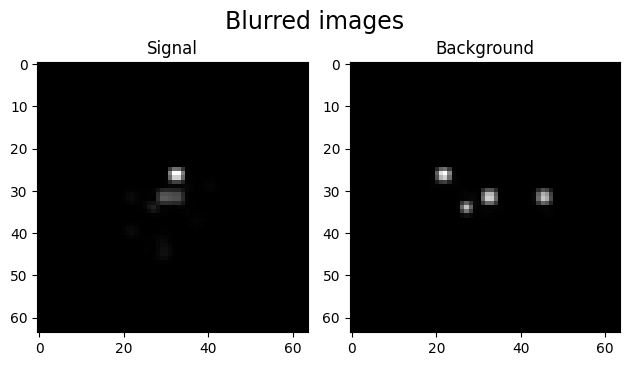

In [10]:
#EXAMPLE IMAGES AFTER BLURRING
plt.figure()
fig, ax = plt.subplots(1,2)
s=io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/1 Blurred images/Signal/S0.tiff")
b=io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/1 Blurred images/Background/B0.tiff")
ax[0].imshow(s, cmap='grey')
ax[0].set_title("Signal")
ax[1].imshow(b, cmap='grey')
ax[1].set_title("Background")
plt.suptitle("Blurred images",y=0.85,fontsize=17)
fig.tight_layout()
plt.savefig('Blurred64.png')
plt.show()

# WEINER FILTER RECOVERY OF IMAGES

In [11]:
# WEINER FILTER RECOVERY
NSR = 0.001
W = np.conj(H) / (np.abs(H)**2 + NSR)


In [12]:
#WEINER RECOVERY ON SIGNAL IMAGES
signal_w=[]
for i in range(len(signal_b)):
    b=signal_b[i]
    B = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(b)))
    b1 = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(B*W))))
    signal_w.append(b1)
    cv2.imwrite("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/2 Weiner images/Signal/"+'S'+str(i)+'.tiff',b1)


In [13]:
#WEINER RECOVERY ON SIGNAL IMAGES
bg_w=[]
for i in range(len(bg_b)):
    b=bg_b[i]
    B = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(b)))
    b1 = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(B*W))))
    bg_w.append(b1)
    cv2.imwrite("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/2 Weiner images/Background/"+'B'+str(i)+'.tiff',b1)


<Figure size 640x480 with 0 Axes>

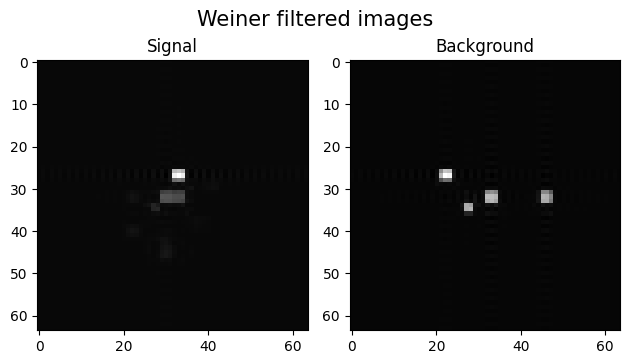

In [17]:
#EXAMPLE IMAGES AFTER WEINER FILTERING
plt.figure()
fig, ax = plt.subplots(1,2)
s1= io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/2 Weiner images/Signal/S0.tiff")
b1= io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/2 Weiner images/Background/B0.tiff")
ax[0].imshow(s1, cmap='grey')
ax[0].set_title("Signal")
ax[1].imshow(b1, cmap='grey')
ax[1].set_title("Background")
plt.suptitle("Weiner filtered images",y=0.85,fontsize=15)
fig.tight_layout()
plt.savefig('Weiner.png')
plt.show()

# AUTOGRAD GRADIENT DESCENT

In [2]:
#Defining TV Function
def TV(a):
    ux, uy = anp.gradient(a)
    g = anp.sqrt(anp.abs(ux)**2 + anp.abs(uy)**2 + 1e-10)
    s = anp.sum(g[:])
    return s

#Defining error function
def data_error(guess, blurred, h):
    G = anp.fft.fftshift(anp.fft.fft2(anp.fft.ifftshift(guess)))
    H = anp.fft.fftshift(anp.fft.fft2(anp.fft.ifftshift(h)))
    err = blurred - anp.real(anp.fft.fftshift(anp.fft.ifft2(anp.fft.ifftshift(G*H))))
    err2 = err**2
    l2err = anp.sum(err2[:])
    return l2err   

In [15]:
# ITERATIVE TV BASED DECONVOLUTION ... starting with Winer filter solution as first guess

#SIGNAL IMAGES 
signal_a=[]
for i in range(len(signal)):
    b=signal_b[i]
    b1=signal_w[i]
    
    gerr = grad(data_error, 0)
    gtv = grad(TV, 0)
    
    alpha = 1
    guess = b1
    t = 0.1
    
    for iter in np.arange(1,11,1):
        
        C1 = data_error(guess, b, h)
        dC1 = gerr(guess, b, h)
        C2 = TV(guess)
        dC2 = gtv(guess)
        C = C1 + alpha*C2
        dC = dC1 + alpha*dC2
        dC = dC / np.linalg.norm(dC)
        donet = 0
        
        while(not donet):
            guess_try = guess - t* np.linalg.norm(guess) * dC
            C1try = data_error(guess_try, b, h)
            C2try = TV(guess_try)
            Ctry = C1try + alpha*C2try
            
            if(Ctry < C):
                donet = 1
                guess = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1
    signal_a.append(guess)
    cv2.imwrite("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Signal/"+'S'+str(i)+'.tiff',guess)


In [16]:
# ITERATIVE TV BASED DECONVOLUTION ... starting with Winer filter solution as first guess

#BACKGROUND IMAGES 
bg_a=[]
for i in range(len(bg)):
    b=bg_b[i]
    b1=bg_w[i]
    
    gerr = grad(data_error, 0)
    gtv = grad(TV, 0)
    
    alpha = 1
    guess = b1
    t = 0.1
    
    for iter in np.arange(1,11,1):
        
        C1 = data_error(guess, b, h)
        dC1 = gerr(guess, b, h)
        C2 = TV(guess)
        dC2 = gtv(guess)
        C = C1 + alpha*C2
        dC = dC1 + alpha*dC2
        dC = dC / np.linalg.norm(dC)
        donet = 0
        
        while(not donet):
            guess_try = guess - t* np.linalg.norm(guess) * dC
            C1try = data_error(guess_try, b, h)
            C2try = TV(guess_try)
            Ctry = C1try + alpha*C2try
            
            if(Ctry < C):
                donet = 1
                guess = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1
    bg_a.append(guess)
    cv2.imwrite("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Background/"+'B'+str(i)+'.tiff',guess)

<Figure size 640x480 with 0 Axes>

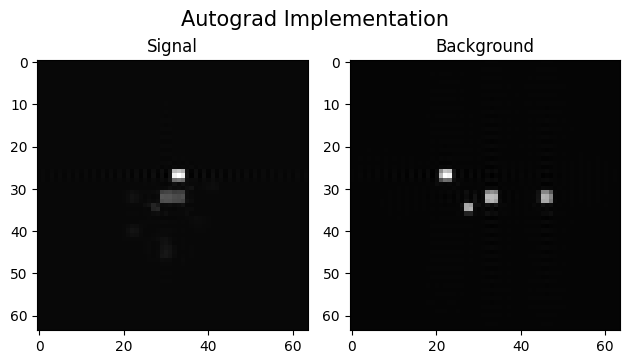

In [18]:
#EXAMPLE IMAGES AFTER WEINER FILTERING
plt.figure()
fig, ax = plt.subplots(1,2)
s2=io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Signal/S0.tiff")
b2=io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Background/B0.tiff")
ax[0].imshow(s2, cmap='grey')
ax[0].set_title("Signal")
ax[1].imshow(b2, cmap='grey')
ax[1].set_title("Background")
plt.suptitle("Autograd Implementation",y=0.85,fontsize=15)
fig.tight_layout()
plt.savefig('Auto.png')
plt.show()

## TESTING CNN ON AUTOGRAD

In [3]:
def images_upload(folder):
    images = []
    names=[]
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            if filename[:1]=='S':
                names.append(0)
            else: names.append(1)
    return images, names

signal_a, s_names_a= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Signal")
bg_a,bg_names_a= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Background")

In [4]:
#CREATING TRAINING TESTING AND VALIDATION DATASETS

x=np.array(signal_a+bg_a) #numpy array of images
y=np.array(s_names_a+bg_names_a) #numpy array of class labels

#split all signal images into 20% test 80% train ==> 0.2 TEST
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
#split 80% train into 25% (0.8*0.25) validation and 75% (0.8*0.75) train ==> 0.6 TRAIN 0.2 VALIDATION
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [5]:
#CREATING THE CNN MODEL
model = Sequential()

# Add the first Convolutional layer with L2 regularization
model.add(Conv2D(32, (11, 11), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(64, 64, 1)))

# Add the first MaxPooling layer
model.add(MaxPooling2D(2, 2))

# Add the second layer: Dropout
model.add(Dropout(0.2))

# Add the second Convolutional layer with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the second MaxPooling layer
model.add(MaxPooling2D(3, 3))

model.add(Dropout(0.2))
# Add the third Convolutional layer with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the third MaxPooling layer
model.add(MaxPooling2D(3, 3))

# Add Local Response Normalization
model.add(Lambda(tf.nn.lrn))

# Flatten the output before the Fully Connected layer
model.add(Flatten())

# Add a Dropout layer before the first Fully Connected layer
model.add(Dropout(0.2))

# Add the Fully Connected layer with 64 units
model.add(Dense(64, activation='relu'))

# Add a Dropout layer before the output layer
model.add(Dropout(0.1))

# Add the output layer with a Sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 32)        3904      
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 27, 27, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)         

In [6]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1.e-3),
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')]
)

In [7]:
#FITTING THE MODEL
history= model.fit(x_train, y_train, epochs=45,batch_size=32,validation_data=(x_val, y_val))

Epoch 1/45


8/8 [==============================] - 3s 82ms/step - loss: 1.3108 - accuracy: 0.5333 - auc: 0.5075 - val_loss: 1.2497 - val_accuracy: 0.4625 - val_auc: 0.4959
Epoch 2/45
8/8 [==============================] - 0s 39ms/step - loss: 1.1902 - accuracy: 0.5417 - auc: 0.5708 - val_loss: 1.1440 - val_accuracy: 0.4625 - val_auc: 0.5264
Epoch 3/45
8/8 [==============================] - 0s 40ms/step - loss: 1.0928 - accuracy: 0.5417 - auc: 0.5501 - val_loss: 1.0534 - val_accuracy: 0.4625 - val_auc: 0.5443
Epoch 4/45
8/8 [==============================] - 0s 39ms/step - loss: 1.0090 - accuracy: 0.5417 - auc: 0.5836 - val_loss: 0.9790 - val_accuracy: 0.4625 - val_auc: 0.5402
Epoch 5/45
8/8 [==============================] - 0s 39ms/step - loss: 0.9381 - accuracy: 0.5458 - auc: 0.6328 - val_loss: 0.9205 - val_accuracy: 0.4625 - val_auc: 0.5814
Epoch 6/45
8/8 [==============================] - 0s 37ms/step - loss: 0.8849 - accuracy: 0.5417 - auc: 0.5987 - val_loss: 0.8769 - val_accurac

In [10]:
#SAVING MODEL WEIGHTS POST TRAINING FOR FUTURE USE
# model.save_weights('CNN_a_200(45).h5')
model.load_weights('CNN_a_200(45).h5')

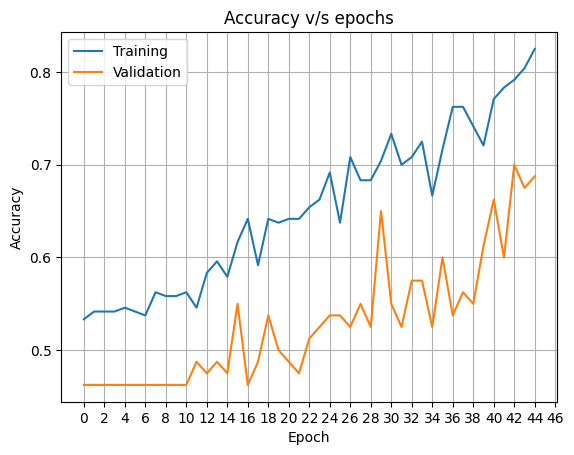

In [8]:
#ACCURACY V/S EPOCHS PLOT
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 2))
ax.set_yticks(np.arange(0, 1., 0.1))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title("Accuracy v/s epochs")
# plt.savefig('Acc_a.png', bbox_inches='tight')
plt.show()

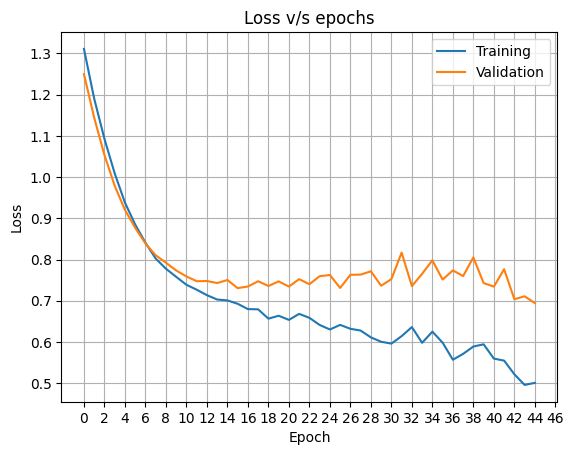

In [9]:
#LOSS V/S EPOCHS PLOT
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 2))
ax.set_yticks(np.arange(0, 2., 0.1))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Loss v/s epochs")
# plt.savefig('Loss_a.png', bbox_inches='tight')
plt.show()

In [11]:
#EVALUATING ACCURACY AND LOSS ON TEST SET

score = model.evaluate(x_test,y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 10ms/step - loss: 0.6651 - accuracy: 0.7625 - auc: 0.8079
Test loss: 0.6650736927986145
Test accuracy: 0.762499988079071


3/3 [==============================] - 0s 8ms/step


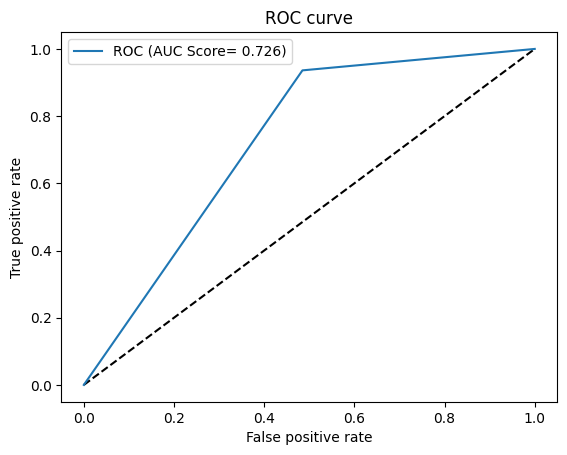

In [12]:
#PLOTTING ROC CURVE
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = model.predict(x_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (AUC Score= {:.3f})'.format(auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('ROC_a.png', bbox_inches='tight')
plt.legend(loc='best')
plt.show()

In [80]:
print("Older weights result: Test loss: 0.949195384979248 \n Test accuracy: 0.4124999940395355 \n")
print("Newly trained model result: Test loss: 0.6650736927986145 \n Test accuracy: 0.762499988079071")

Older weights result: Test loss: 0.949195384979248 
 Test accuracy: 0.4124999940395355 

Newly trained model result: Test loss: 0.6650736927986145 
 Test accuracy: 0.762499988079071


# NUMPY GRADIENT DESCENT

In [21]:
#Definitions
def TV_np(a):
    ux, uy = np.gradient(a)
    g = np.sqrt(np.abs(ux)**2 + np.abs(uy)**2 + 1e-10)
    s = np.sum(g[:])
    return s


def gradd(Gin, Gout, alpha):
    #First term
    term1=-2*(Gout-Gin)
    
    #Second term
    delGin= np.gradient(Gin)
    gx=delGin[1]
    gy=delGin[0]
    denom = np.sqrt(gx**2 + gy**2 + np.random.rand(64,64))
    
    term2= alpha*(np.gradient(np.divide(gx,denom))[1]+ np.gradient(np.divide(gy,denom),1)[0])
    delC= term1 - term2
    return delC


def Cmin(Gout,Gin,alpha):
    C_Gin= np.linalg.norm((Gout-Gin))**2 + alpha*TV_np(Gin)
    return C_Gin

In [34]:
#Numpy implementation

#SIGNAL IMAGES
signal_n=[]

for i in range(len(signal)):
    b=signal_b[i]
    b1=signal_w[i]
    
    Gin= np.array(b1)
    Gout=np.array(b)
    
    t = 0.1
    alpha=1
    guess_np=b1
    
    for iter in np.arange(1,11,1):
        dC = gradd(guess_np, Gout, alpha)
        donet = 0
        C=Cmin(Gout,guess_np,alpha)
        while(not donet):
            guess_try = guess_np - t*dC
            Ctry=Cmin(Gout,guess_try,alpha)
           
            
            if(Ctry < C):
                donet = 1
                guess_np = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1 
    signal_n.append(guess_np)
    cv2.imwrite("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Signal/"+'S'+str(i)+'.tiff',guess_np)

In [24]:
#Numpy implementation

#BACKGROUND IMAGES
bg_n=[]

for i in range(len(signal)):
    b=bg_b[i]
    b1=bg_w[i]
    
    Gin= np.array(b1)
    Gout=np.array(b)
    
    t = 0.1
    alpha=1
    guess_np=b1
    
    for iter in np.arange(1,11,1):
        dC = gradd(guess_np, Gout, alpha)
        donet = 0
        C=Cmin(Gout,guess_np,alpha)
        while(not donet):
            guess_try = guess_np - t*dC
            Ctry=Cmin(Gout,guess_try,alpha)
           
            
            if(Ctry < C):
                donet = 1
                guess_np = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1 
    bg_n.append(guess_np)
    cv2.imwrite("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Background/"+'B'+str(i)+'.tiff',guess_np)

<Figure size 640x480 with 0 Axes>

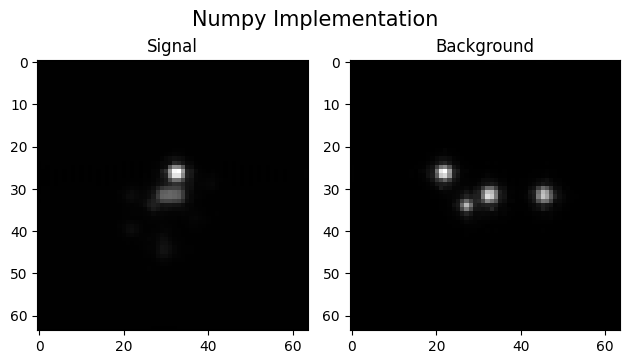

In [35]:
#EXAMPLE IMAGES AFTER WEINER FILTERING
plt.figure()
fig, ax = plt.subplots(1,2)
s3=io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Signal/S0.tiff")
b3=io.imread("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Background/B0.tiff")
ax[0].imshow(s3, cmap='grey')
ax[0].set_title("Signal")
ax[1].imshow(b3, cmap='grey')
ax[1].set_title("Background")
plt.suptitle("Numpy Implementation",y=0.85,fontsize=15)
fig.tight_layout()
plt.savefig('Numpy.png')
plt.show()

## TESTING CNN ON NUMPY

In [133]:
def images_upload(folder):
    images = []
    names=[]
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            if filename[:1]=='S':
                names.append(0)
            else: names.append(1)
    return images, names

signal_a, s_names_a= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Signal")
bg_a,bg_names_a= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Background")

In [188]:
#CREATING TRAINING TESTING AND VALIDATION DATASETS

x=np.array(signal_a+bg_a) #numpy array of images
y=np.array(s_names_a+bg_names_a) #numpy array of class labels

#split all signal images into 20% test 80% train ==> 0.2 TEST
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
#split 80% train into 25% (0.8*0.25) validation and 75% (0.8*0.75) train ==> 0.6 TRAIN 0.2 VALIDATION
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [193]:
#CREATING THE CNN MODEL
model = Sequential()

# Add the first Convolutional layer with L2 regularization
model.add(Conv2D(32, (11, 11), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(64, 64, 1)))

# Add the first MaxPooling layer
model.add(MaxPooling2D(2, 2))

# Add the second layer: Dropout
model.add(Dropout(0.2))

# Add the second Convolutional layer with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the second MaxPooling layer
model.add(MaxPooling2D(3, 3))

model.add(Dropout(0.2))
# Add the third Convolutional layer with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the third MaxPooling layer
model.add(MaxPooling2D(3, 3))

# Add Local Response Normalization
model.add(Lambda(tf.nn.lrn))

# Flatten the output before the Fully Connected layer
model.add(Flatten())

# Add a Dropout layer before the first Fully Connected layer
model.add(Dropout(0.2))

# Add the Fully Connected layer with 64 units
model.add(Dense(64, activation='relu'))

# Add a Dropout layer before the output layer
model.add(Dropout(0.1))

# Add the output layer with a Sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 54, 54, 32)        3904      
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 27, 27, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_76 (Dropout)        (None, 27, 27, 32)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 dropout_77 (Dropout)        (None, 8, 8, 32)        

In [194]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1.e-3),
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')]
)

In [195]:
#FITTING THE MODEL
history= model.fit(x_train, y_train, epochs=45,batch_size=32,validation_data=(x_val, y_val))

Epoch 1/45
8/8 [==============================] - 4s 139ms/step - loss: 1.3041 - accuracy: 0.5458 - auc_17: 0.4716 - val_loss: 1.2336 - val_accuracy: 0.4625 - val_auc_17: 0.5566
Epoch 2/45
8/8 [==============================] - 0s 54ms/step - loss: 1.1779 - accuracy: 0.5417 - auc_17: 0.5020 - val_loss: 1.1282 - val_accuracy: 0.4625 - val_auc_17: 0.6213
Epoch 3/45
8/8 [==============================] - 0s 54ms/step - loss: 1.0707 - accuracy: 0.5417 - auc_17: 0.6015 - val_loss: 1.0318 - val_accuracy: 0.4625 - val_auc_17: 0.6493
Epoch 4/45
8/8 [==============================] - 0s 58ms/step - loss: 0.9878 - accuracy: 0.5417 - auc_17: 0.6299 - val_loss: 0.9556 - val_accuracy: 0.4625 - val_auc_17: 0.6590
Epoch 5/45
8/8 [==============================] - 0s 53ms/step - loss: 0.9198 - accuracy: 0.5417 - auc_17: 0.5993 - val_loss: 0.9014 - val_accuracy: 0.4625 - val_auc_17: 0.6505
Epoch 6/45
8/8 [==============================] - 0s 55ms/step - loss: 0.8688 - accuracy: 0.5417 - auc_17: 0.5541 

In [175]:
#SAVING MODEL WEIGHTS POST TRAINING FOR FUTURE USE
# model.save_weights('CNN_n_200(50).h5')
# model.load_weights('CNN_n_200(45).h5')

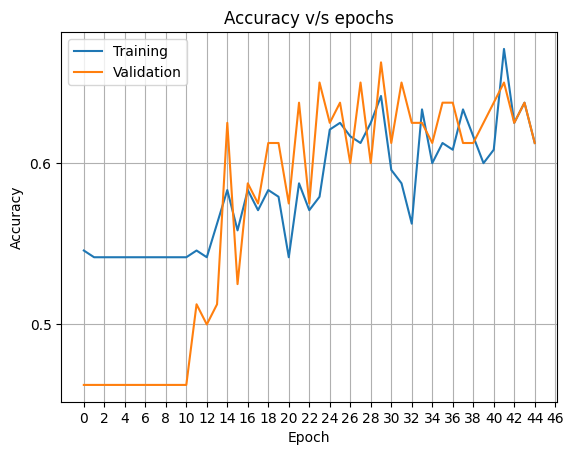

In [196]:
#ACCURACY V/S EPOCHS PLOT
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 2))
ax.set_yticks(np.arange(0, 1., 0.1))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title("Accuracy v/s epochs")
plt.savefig('Acc_n.png', bbox_inches='tight')
plt.show()

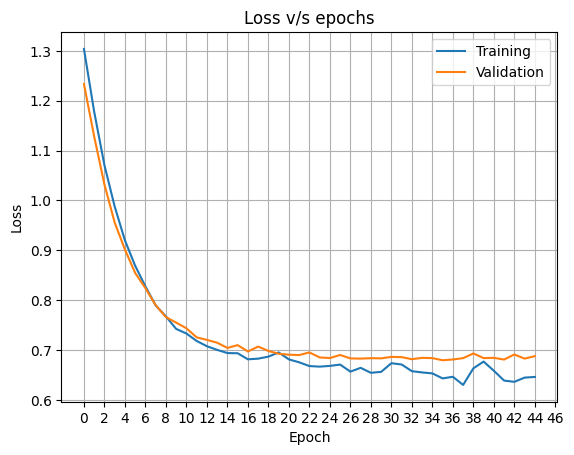

In [197]:
#LOSS V/S EPOCHS PLOT
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 2))
ax.set_yticks(np.arange(0, 2., 0.1))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Loss v/s epochs")
plt.savefig('Loss_n.png', bbox_inches='tight')
plt.show()

In [198]:
#EVALUATING ACCURACY AND LOSS ON TEST SET

score = model.evaluate(x_test,y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 15ms/step - loss: 0.7573 - accuracy: 0.5500 - auc_17: 0.5374
Test loss: 0.7573243379592896
Test accuracy: 0.550000011920929


3/3 [==============================] - 0s 14ms/step


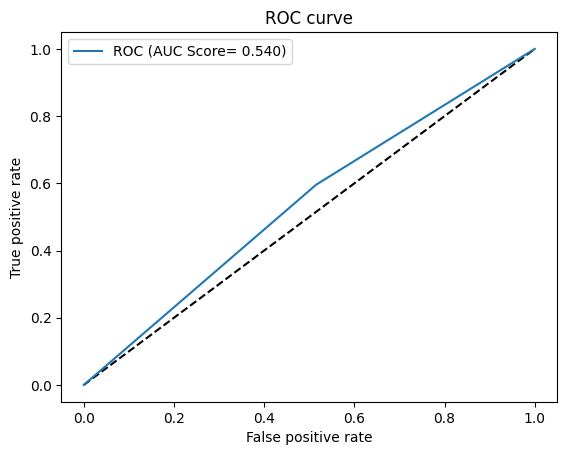

In [199]:
#PLOTTING ROC CURVE
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = model.predict(x_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (AUC Score= {:.3f})'.format(auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('ROC_n.png', bbox_inches='tight')
plt.legend(loc='best')
plt.show()

In [158]:
print("Older weights result: Test loss: 0.964759349822998 \n Test accuracy: 0.4124999940395355 \n ")
print("Newly trained model result: Test loss: 0.7052339911460876 \n Test accuracy: 0.625")

Older weights result: Test loss: 0.964759349822998 
 Test accuracy: 0.4124999940395355 
 
Newly trained model result: Test loss: 0.7052339911460876 
 Test accuracy: 0.625


# METRICS

In [4]:
signal_w, s_w= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/2 Weiner images/Signal")
bg_w, b_w= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/2 Weiner images/Background")

signal_a, s_a= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Signal")
bg_a, b_a= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/3 Autograd images/Background")

signal_n, s_n= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Signal")
bg_n, b_n= images_upload("D:/Msc Thesis notebooks/Preprocessing Autograd and Numpy/64/4 Numpy images/Background")

In [8]:
mean_signal_w= np.array(signal_w).mean(axis=0)
mean_signal_a= np.array(signal_a).mean(axis=0)
mean_signal_n= np.array(signal_n).mean(axis=0)
mean_bg_w= np.array(bg_w).mean(axis=0)
mean_bg_a= np.array(bg_a).mean(axis=0)
mean_bg_n= np.array(bg_n).mean(axis=0)

<Figure size 640x480 with 0 Axes>

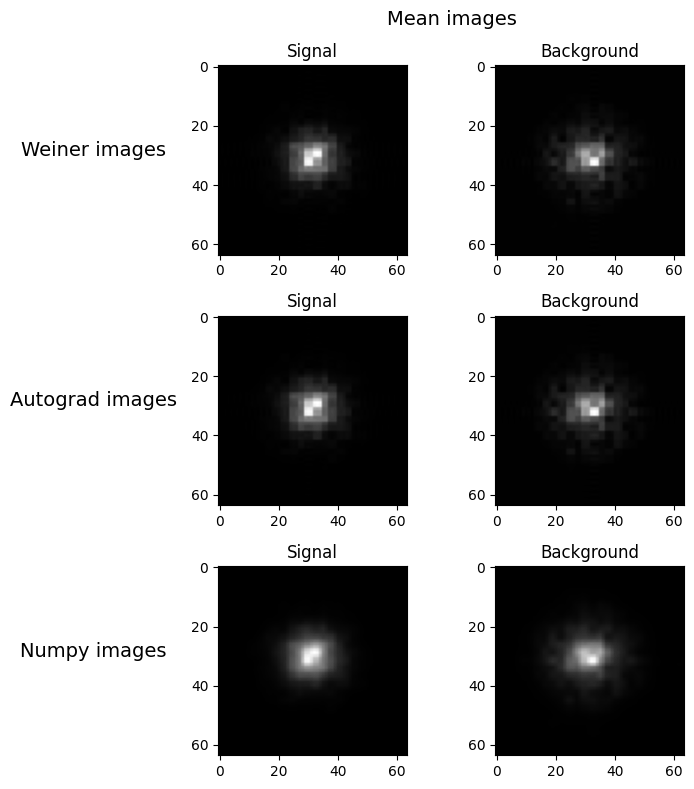

In [11]:
#EXAMPLE IMAGES AFTER BLURRING
plt.figure()
fig, ax = plt.subplots(3,2,figsize=(8,8))
ax[0,0].imshow(mean_signal_w, cmap='grey')
ax[0,0].set_title("Signal")
ax[0,0].set_ylabel("Weiner images", fontsize=14, rotation='horizontal',labelpad=70)
ax[0,1].imshow(mean_bg_w, cmap='grey')
ax[0,1].set_title("Background")

ax[1,0].imshow(mean_signal_a, cmap='grey')
ax[1,0].set_title("Signal")
ax[1,0].set_ylabel("Autograd images", fontsize=14, rotation='horizontal',labelpad=70)
ax[1,1].imshow(mean_bg_a, cmap='grey')
ax[1,1].set_title("Background")

ax[2,0].imshow(mean_signal_n, cmap='grey')
ax[2,0].set_title("Signal")
ax[2,0].set_ylabel("Numpy images", fontsize=14, rotation='horizontal',labelpad=70)
ax[2,1].imshow(mean_bg_n, cmap='grey')
ax[2,1].set_title("Background")


plt.suptitle("Mean images",fontsize=14,x=0.6)
fig.tight_layout()
plt.savefig('ALL.png')
plt.show()

In [31]:
#WEINER
img1 = cv2.imread("mean_signal_w.jpg")
img2 = cv2.imread("mean_bg_w.jpg")

hist_img1 = cv2.calcHist([img1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img1[0, 0, 0] = 0
cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_img2 = cv2.calcHist([img2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img2[0, 0, 0] = 0
cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Find the metric value
metric_val_w = cv2.compareHist(hist_img2, hist_img1, cv2.HISTCMP_BHATTACHARYYA)
ssq_val_w= np.mean((img1-img2)**2)

In [32]:
#AUTOGRAD
img1 = cv2.imread("mean_signal_a.jpg")
img2 = cv2.imread("mean_bg_a.jpg")

hist_img1 = cv2.calcHist([img1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img1[0, 0, 0] = 0
cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_img2 = cv2.calcHist([img2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img2[0, 0, 0] = 0
cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Find the metric value
metric_val_a = cv2.compareHist(hist_img2, hist_img1, cv2.HISTCMP_BHATTACHARYYA)
ssq_val_a= np.mean((img1-img2)**2)

In [33]:
#NUMPY
img1 = cv2.imread("mean_signal_n.jpg")
img2 = cv2.imread("mean_bg_n.jpg")

hist_img1 = cv2.calcHist([img1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img1[0, 0, 0] = 0
cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_img2 = cv2.calcHist([img2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img2[0, 0, 0] = 0
cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Find the metric value
metric_val_n = cv2.compareHist(hist_img2, hist_img1, cv2.HISTCMP_BHATTACHARYYA)
ssq_val_n= np.mean((img1-img2)**2)

In [34]:
print("\033[1m"+"Distance between mean signal and mean background images: \n ")
print("Bhattacharya distance"+'\033[0m')
print("Weiner:", np.round(metric_val_w,3))
print("Autograd:", np.round(metric_val_a,3))
print("Numpy:", np.round(metric_val_n,3),'\n')
print("\033[1m"+"SSQ distance"+'\033[0m')
print("Weiner:", np.round(ssq_val_w,3))
print("Autograd:", np.round(ssq_val_a,3))
print("Numpy:", np.round(ssq_val_n,3))

Distance between mean signal and mean background images: 
 
Bhattacharya distance
Weiner: 0.279
Autograd: 0.332
Numpy: 0.151 

SSQ distance
Weiner: 15.703
Autograd: 15.397
Numpy: 14.402
